In [1]:
# importing necessary packages

import os
import numpy as np
import pandas as pd
import math
#import tensorflow as tf
#from tensorflow.keras.models import Sequential
#from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
#from tensorflow.keras.callbacks import EarlyStopping

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

from iterstrat.ml_stratifiers import MultilabelStratifiedShuffleSplit

import pickle

In [2]:
# setting a seed

seed = 42
np.random.seed(seed)
torch.manual_seed(seed)

In [ ]:
# defining paths

train_dir  = "data/train/final_data"
meta_dir   = "metadata/BP"
test_dir       = "data/test"

os.makedirs(meta_dir, exist_ok=True) # to store working files

x_path      = os.path.join(train_dir, "X_train.npy")
y_bp_path   = os.path.join(train_dir, "Y_bp_train.npy")

x_test_path    = os.path.join(test_dir, "X_test.npy")
test_ids_path  = os.path.join(test_dir, "test_ids.txt")

bp_keep_npy    = os.path.join(meta_dir, "go_terms.npy")
go_bp_map_pkl  = os.path.join(meta_dir, "go_map.pkl")
BP_model_path  = os.path.join(meta_dir, "bp_model.pth")
scaler_path    = os.path.join(meta_dir, "embed_scaler.pkl")
pred_out_csv   = os.path.join(meta_dir, "bp_predictions.csv")

In [4]:
# loading data

X      = np.load(x_path)      # preprocessed training data = (123696,2024)
Y_bp   = np.load(y_bp_path)   # CC training labels         = (123969, 677)

print("X:", X.shape, "Y_bp:", Y_bp.shape) #checkpoint

X: (123969, 2024) Y_bp: (123969, 1466)


In [5]:
interpro_dim = 1000
embeded_dim = X.shape[1] - interpro_dim
assert embeded_dim > 0, "Embedding dimension inferred <= 0; check interpro_dim."

X_domains = X[:, :interpro_dim].astype(np.float32)  # keep as 0/1 float
X_embed   = X[:, interpro_dim:].astype(np.float32)

In [6]:
# BP label filtering

use_bp_mask = True # can be turned of, not recommended
if use_bp_mask:
    mask = (Y_bp.sum(axis=1) > 0)
    X_domains = X_domains[mask]
    X_embed   = X_embed[mask]
    Y_bp      = Y_bp[mask]
    print("After BP mask, X:", (X_domains.shape[0], X_domains.shape[1] + X_embed.shape[1]), "Y:", Y_bp.shape)

After BP mask, X: (83064, 2024) Y: (83064, 1466)


In [7]:
# Data split

#msss makes sure all mf labels appear at least once in both train and validation sets
#msss = MultilabelStratifiedShuffleSplit(
#    n_splits=1,
#    test_size=0.2,
#    random_state=seed
#)

#train_idx, val_idx = next(msss.split(X_scaled, Y_bp))

#x_train = X_scaled[train_idx]
#x_val   = X_scaled[val_idx]
#y_train = Y_bp[train_idx]
#y_val   = Y_bp[val_idx]

#y_train = y_train.astype(np.float32)
#y_val   = y_val.astype(np.float32)

#print("Train:", x_train.shape, y_train.shape, "Val:", x_val.shape, y_val.shape)

In [8]:
# msss takes some time with BP due to so many labels so I just saved the split
#split_path = "metadata/BP/msss_split.npz"
#np.savez(split_path, train_idx=train_idx, val_idx=val_idx)

In [9]:
# How to load it:
split_path = "metadata/BP/msss_split.npz"
data = np.load(split_path)
train_idx = data["train_idx"]
val_idx = data["val_idx"]

X_domains_train = X_domains[train_idx]
X_domains_val   = X_domains[val_idx]

X_embed_train = X_embed[train_idx]
X_embed_val   = X_embed[val_idx]

y_train = Y_bp[train_idx].astype(np.float32)
y_val   = Y_bp[val_idx].astype(np.float32)

In [10]:
scaler = StandardScaler()
X_embed_train_scaled = scaler.fit_transform(X_embed_train)
X_embed_val_scaled   = scaler.transform(X_embed_val)

with open(scaler_path, "wb") as f:
    pickle.dump(scaler, f)

In [11]:
X_train = np.concatenate(
    [X_domains_train, X_embed_train_scaled],
    axis=1
)

X_val = np.concatenate(
    [X_domains_val, X_embed_val_scaled], 
    axis=1
)


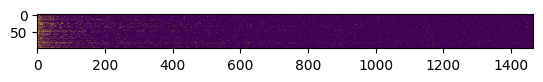

In [12]:
import matplotlib.pyplot as plt
plt.imshow(Y_bp[0:100])
plt.show()

In [13]:
class Model(nn.Module):
  def __init__(self,input_dim=2024, hidden_dim=1024, output_dim=1466, dropout=0.15):
    super().__init__()
    self.pipeline = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            nn.LeakyReLU(),
            nn.Dropout(dropout),

            nn.Linear(hidden_dim, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            nn.LeakyReLU(),
            nn.Dropout(dropout),

            nn.Linear(hidden_dim, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            nn.LeakyReLU(),
            nn.Dropout(dropout),

            nn.Linear(hidden_dim, output_dim)
        )

  def forward(self, x):
   return self.pipeline(x)

In [14]:
device = torch.device("cpu")

In [15]:
batch_size = max(1, X_train.shape[0] // 100)

X_train_t = torch.tensor(X_train, dtype=torch.float32, device=device)
X_val_t   = torch.tensor(X_val, dtype=torch.float32, device=device)

y_train_t = torch.tensor(y_train, dtype=torch.float32, device=device)
y_val_t   = torch.tensor(y_val, dtype=torch.float32, device=device)


In [16]:
model_bp = Model(input_dim=2024).to(device)

#if os.path.exists(train_dir + "/model_bp.pth"):
#    model_bp.load_state_dict(torch.load(train_dir + "/model_bp.pth"))
# y_train is numpy float32 (0/1)
criterion = torch.nn.BCEWithLogitsLoss()

optimizer = torch.optim.Adam(model_bp.parameters(), lr=0.001)

In [17]:
best_val = float("inf")
patience = 5
bad_epochs = 0

for epoch in range(50):
    model_bp.train()
    epoch_loss, num_batches = 0.0, 0

    for b in range(100):
        start, end = batch_size*b, batch_size*(b+1)
        if start >= len(X_train_t): break

        batch = X_train_t[start:end]
        Y_true = y_train_t[start:end]

        optimizer.zero_grad()
        Y_pred = model_bp(batch)
        loss = criterion(Y_pred, Y_true)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model_bp.parameters(), 1.0)
        optimizer.step()

        epoch_loss += loss.item()
        num_batches += 1

    avg_loss = epoch_loss / num_batches

    model_bp.eval()
    with torch.no_grad():
        val_logits = model_bp(X_val_t)
        val_loss = criterion(val_logits, y_val_t).item()

    print(f"Epoch {epoch+1}/50 | train: {avg_loss:.4f} | val: {val_loss:.4f}")

    if val_loss < best_val - 1e-5:
        best_val = val_loss
        bad_epochs = 0
        torch.save(model_bp.state_dict(), BP_model_path)
    else:
        bad_epochs += 1
        if bad_epochs >= patience:
            print(f"Early stopping at epoch {epoch+1}. Best val: {best_val:.4f}")
            break


Epoch 1/50 | train: 0.0948 | val: 0.0679
Epoch 2/50 | train: 0.0662 | val: 0.0646
Epoch 3/50 | train: 0.0633 | val: 0.0631
Epoch 4/50 | train: 0.0613 | val: 0.0621
Epoch 5/50 | train: 0.0597 | val: 0.0614
Epoch 6/50 | train: 0.0582 | val: 0.0609
Epoch 7/50 | train: 0.0569 | val: 0.0605
Epoch 8/50 | train: 0.0556 | val: 0.0603
Epoch 9/50 | train: 0.0544 | val: 0.0601
Epoch 10/50 | train: 0.0532 | val: 0.0601
Epoch 11/50 | train: 0.0522 | val: 0.0602
Epoch 12/50 | train: 0.0510 | val: 0.0600
Epoch 13/50 | train: 0.0500 | val: 0.0600
Epoch 14/50 | train: 0.0490 | val: 0.0604
Epoch 15/50 | train: 0.0481 | val: 0.0605
Epoch 16/50 | train: 0.0472 | val: 0.0605
Epoch 17/50 | train: 0.0464 | val: 0.0609
Epoch 18/50 | train: 0.0456 | val: 0.0611
Early stopping at epoch 18. Best val: 0.0600


In [18]:
val_prob_bp = model_bp(torch.tensor(X_val)).detach().numpy()
print(val_prob_bp.shape)

(16675, 1466)


In [19]:
# defininf micro f1

def micro_f1(y_true, y_prob, thr):
    y_pred = (y_prob >= thr).astype(np.int8)
    tp = (y_pred * y_true).sum()
    fp = (y_pred * (1 - y_true)).sum()
    fn = ((1 - y_pred) * y_true).sum()
    if tp == 0:
        return 0.0
    precision = tp / (tp + fp + 1e-9)
    recall    = tp / (tp + fn + 1e-9)
    return float(2 * precision * recall / (precision + recall + 1e-9))

In [20]:
# threshold scan on validation set

thresholds = np.arange(0.01, 0.51, 0.01)
best_thr, best_score = None, -1.0

for t in thresholds:
    y_pred = (val_prob_bp > t).astype(np.int32)
    s = f1_score(y_val, y_pred, average="micro", zero_division=0)
    if s > best_score:
        best_score = s
        best_thr = t

print("Best threshold (micro-F1 scan):", best_thr, "score:", best_score)

#best_thr_conv, best_score_conv = None, -1.0
#for t in thresholds:
#    s = micro_f1(y_val, val_prob_conv, t)
#    if s > best_score_conv:
#        best_score_conv = s
 #       best_thr_conv = t

#print("Best threshold 2 (micro-F1 scan):", best_thr_bp, "score:", best_score_bp)
#print("Best threshold conv (micro-F1 scan):", best_thr_conv, "score:", best_score_conv)

Best threshold (micro-F1 scan): 0.01 score: 0.42530016187196973


In [21]:
model_bp.eval()
with torch.no_grad():
    val_logits = model_bp(X_val_t)
    val_probs = torch.sigmoid(val_logits).cpu().numpy()

y_pred_05 = (val_probs > 0.5).astype(int)
y_pred_01 = (val_probs > 0.1).astype(int)
y_pred_005 = (val_probs > 0.05).astype(int)

print("Mean prob:", val_probs.mean())
print("Predicted positive rate @0.5:", y_pred_05.mean())
print("Predicted positive rate @0.1:", y_pred_01.mean())
print("Predicted positive rate @0.05:", y_pred_005.mean())

print("Micro F1 @0.5:", f1_score(y_val, y_pred_05, average="micro", zero_division=0))
print("Micro F1 @0.1:", f1_score(y_val, y_pred_01, average="micro", zero_division=0))
print("Micro F1 @0.05:", f1_score(y_val, y_pred_005, average="micro", zero_division=0))

print("Macro F1 @0.05:", f1_score(y_val, y_pred_005, average="macro", zero_division=0))

Mean prob: 0.01900124
Predicted positive rate @0.5: 0.01007782602559566
Predicted positive rate @0.1: 0.038513226333627186
Predicted positive rate @0.05: 0.06157832407125223
Micro F1 @0.5: 0.426236325829491
Micro F1 @0.1: 0.4389375447890246
Micro F1 @0.05: 0.3673016503805771
Macro F1 @0.05: 0.24750033387928455


In [22]:
y_zero = np.zeros_like(y_val)
print("Zero baseline micro F1:", f1_score(y_val, y_zero, average="micro", zero_division=0))
print("Zero baseline macro F1:", f1_score(y_val, y_zero, average="macro", zero_division=0))

Zero baseline micro F1: 0.0
Zero baseline macro F1: 0.0


In [23]:
# precision-recall curve on the validation set
from sklearn.metrics import precision_recall_curve

y_true = y_val.flatten()
y_score = val_prob_bp.flatten()

precision, recall, _ = precision_recall_curve(y_true, y_score)


In [24]:
f1 = (2 * precision * recall) / (precision + recall + 1e-12)

best_idx = np.argmax(f1)
best_f1 = f1[best_idx]
best_p = precision[best_idx]
best_r = recall[best_idx]

print(f"Max micro-F1: {best_f1:.4f}")
print(f"At threshold: {best_thr:.4f}")
print(f"Precision: {best_p:.4f}, Recall: {best_r:.4f}")

Max micro-F1: 0.4827
At threshold: 0.0100
Precision: 0.4906, Recall: 0.4749


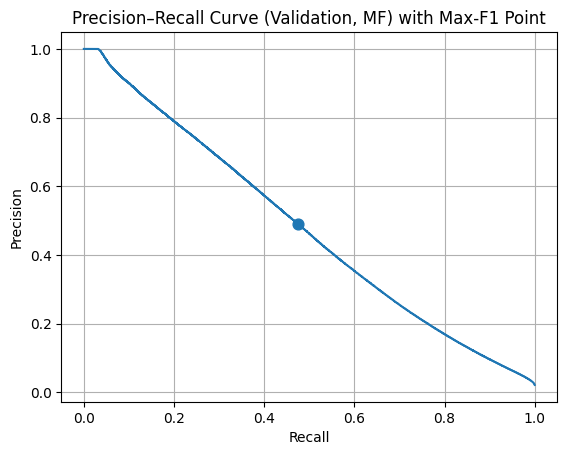

In [25]:
# Plot PR curve + mark max-F1 point
import matplotlib.pyplot as plt
plt.figure()
plt.plot(recall, precision)
plt.scatter([best_r], [best_p], s=60)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision–Recall Curve (Validation, MF) with Max-F1 Point")
plt.grid(True)
plt.show()

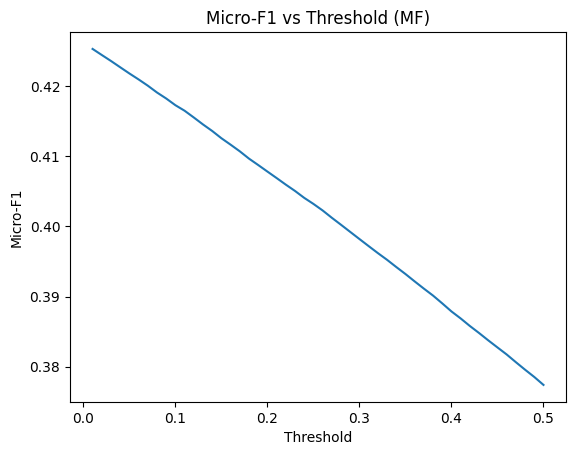

In [26]:
# checking the microF1 vs threshold relationship

scores = []
for t in thresholds:
    scores.append(micro_f1(y_val, val_prob_bp, t))

plt.plot(thresholds, scores)
plt.xlabel("Threshold")
plt.ylabel("Micro-F1")
plt.title("Micro-F1 vs Threshold (MF)")
plt.show()

In [27]:
import numpy as np

def fit_per_label_thresholds(y_true, probs, thresholds=None):
    """
    y_true: (N, L) binary {0,1}
    probs : (N, L) probabilities in [0,1]
    returns:
      best_thr: (L,) threshold per label
    """
    if thresholds is None:
        thresholds = np.concatenate([
            np.arange(0.001, 0.011, 0.001),
            np.arange(0.01, 0.51, 0.01),
        ])

    N, L = y_true.shape
    best_thr = np.full(L, 0.5, dtype=np.float32)

    y_true = y_true.astype(np.int32)

    for j in range(L):
        yt = y_true[:, j]
        if yt.sum() == 0:
            continue  # no positives → threshold irrelevant

        pj = probs[:, j]
        best_f1 = 0.0

        for t in thresholds:
            yp = (pj > t).astype(np.int32)
            tp = (yp & yt).sum()
            fp = (yp & (1 - yt)).sum()
            fn = ((1 - yp) & yt).sum()

            denom = 2 * tp + fp + fn
            if denom == 0:
                continue

            f1 = 2 * tp / denom
            if f1 > best_f1:
                best_f1 = f1
                best_thr[j] = t

    return best_thr


In [28]:
thr_per_label = fit_per_label_thresholds(y_val, val_prob_bp)

y_pred_val = (val_prob_bp > thr_per_label[None, :]).astype(np.int32)

print("Micro F1 (per-label thr):",
      f1_score(y_val, y_pred_val, average="micro", zero_division=0))
print("Macro F1 (per-label thr):",
      f1_score(y_val, y_pred_val, average="macro", zero_division=0))

Micro F1 (per-label thr): 0.426927087043525
Macro F1 (per-label thr): 0.19512394214142847


In [29]:
np.save("metadata/BP/per_label_thresholds.npy", thr_per_label)

In [31]:
print("Threshold stats:")
print("min:", thr_per_label.min())
print("mean:", thr_per_label.mean())
print("max:", thr_per_label.max())

print("Labels with very low threshold (<0.02):",
      (thr_per_label < 0.02).sum())

Threshold stats:
min: 0.001
mean: 0.12938677
max: 0.5
Labels with very low threshold (<0.02): 741


In [32]:
def predict_topk(probs: np.ndarray, k: int) -> np.ndarray:
    """
    probs: (N, L) float probabilities
    returns y_pred: (N, L) {0,1} where each row has exactly k ones
    """
    N, L = probs.shape
    k = int(max(1, min(k, L)))

    # argpartition is O(L) per row and faster than full sort
    idx = np.argpartition(probs, -k, axis=1)[:, -k:]  # (N, k)

    y_pred = np.zeros((N, L), dtype=np.int32)
    rows = np.arange(N)[:, None]
    y_pred[rows, idx] = 1
    return y_pred

def eval_topk(y_true: np.ndarray, probs: np.ndarray, k: int):
    y_pred = predict_topk(probs, k)
    micro = f1_score(y_true, y_pred, average="micro", zero_division=0)
    macro = f1_score(y_true, y_pred, average="macro", zero_division=0)
    return micro, macro


In [33]:
# Average positives per sample in validation (use as a guide)
avg_pos = y_val.sum(axis=1).mean()
print("Avg positives per sample (val):", avg_pos)

# Define a search range for k (adjust if you want)
k_min = 1
k_max = int(min(200, max(20, round(avg_pos * 5))))  # cap so it doesn't get huge
k_values = list(range(k_min, k_max + 1, 5))          # step by 5 for speed
if 1 not in k_values:
    k_values = [1] + k_values

best_k, best_micro, best_macro = None, -1.0, None
for k in k_values:
    micro, macro = eval_topk(y_val, val_probs, k)
    if micro > best_micro:
        best_micro = micro
        best_macro = macro
        best_k = k

print(f"Best k: {best_k} | micro-F1: {best_micro:.4f} | macro-F1: {best_macro:.4f}")


Avg positives per sample (val): 31.65889
Best k: 31 | micro-F1: 0.4443 | macro-F1: 0.2196


In [34]:
y_pred_per_label = (val_probs > thr_per_label[None, :]).astype(np.int32)
micro_pl = f1_score(y_val, y_pred_per_label, average="micro", zero_division=0)
macro_pl = f1_score(y_val, y_pred_per_label, average="macro", zero_division=0)
print(f"Per-label thr | micro-F1: {micro_pl:.4f} | macro-F1: {macro_pl:.4f}")

Per-label thr | micro-F1: 0.1397 | macro-F1: 0.1343


In [35]:
micro_k, macro_k = eval_topk(y_val, val_probs, best_k)
print(f"Top-k (k={best_k}) | micro-F1: {micro_k:.4f} | macro-F1: {macro_k:.4f}")


Top-k (k=31) | micro-F1: 0.4443 | macro-F1: 0.2196


In [36]:
print("Loading:", bp_keep_npy)
print("Loading:", go_bp_map_pkl)

if not os.path.exists(bp_keep_npy):
    raise FileNotFoundError(f"Missing file: {bp_keep_npy}")

if not os.path.exists(go_bp_map_pkl):
    raise FileNotFoundError(f"Missing file: {go_bp_map_pkl}")

# Load metadata
bp_keep = np.load(bp_keep_npy, allow_pickle=True).tolist()

with open(go_bp_map_pkl, "rb") as f:
    go_bp_map = pickle.load(f)


# Final consistency check
assert len(bp_keep) == y_train.shape[1], "Mismatch: bp_keep vs Y_bp columns"
assert set(go_bp_map.values()) == set(range(len(bp_keep))), "GO index mapping is broken"

print("BP metadata loaded successfully.")

Loading: metadata/BP\go_terms.npy
Loading: metadata/BP\go_map.pkl
BP metadata loaded successfully.


In [43]:
# test data loading

X_test = np.load(x_test_path)

# metadata loading

bp_keep = np.load(f"{meta_dir}/go_terms.npy", allow_pickle=True)
with open(f"{meta_dir}/go_map.pkl", "rb") as f:
    go_bp_map = pickle.load(f)

# inverse mapping column index to GO term
inv_go_bp_map = {v: k for k, v in go_bp_map.items()}

# test ids loading

with open(test_ids_path, "r") as f:
        test_ids = [line.strip() for line in f if line.strip()]

In [50]:
# Test data normalization

# loading scaler
with open(scaler_path, "rb") as f:
    scaler = pickle.load(f)

# Separating InterPro and ProtT5 features exactly as in training
interpro_dim = 1000
Xtest_domains = X_test[:, :interpro_dim].astype(np.float32)
Xtest_embed   = X_test[:, interpro_dim:].astype(np.float32)

# Scaling
Xtest_embed_scaled = scaler.transform(Xtest_embed)

# Recombining
X_test_scaled = np.concatenate(
    [Xtest_domains, Xtest_embed_scaled],
    axis=1
)

#into a tensor
X_test_t = torch.tensor(
    X_test_scaled,
    dtype=torch.float32,
    device=device
)

In [49]:
device = torch.device("cpu")
model = Model(input_dim=2024).to(device)
model.load_state_dict(torch.load(BP_model_path, map_location=device))
model.eval()

C:\Users\tusev\AppData\Local\Temp\ipykernel_8984\4270045126.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(BP_model_path, map_location=

Model(
  (pipeline): Sequential(
    (0): Linear(in_features=2024, out_features=1024, bias=True)
    (1): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01)
    (3): Dropout(p=0.15, inplace=False)
    (4): Linear(in_features=1024, out_features=1024, bias=True)
    (5): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): LeakyReLU(negative_slope=0.01)
    (7): Dropout(p=0.15, inplace=False)
    (8): Linear(in_features=1024, out_features=1024, bias=True)
    (9): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.01)
    (11): Dropout(p=0.15, inplace=False)
    (12): Linear(in_features=1024, out_features=1466, bias=True)
  )
)

In [52]:
with torch.no_grad():
    test_logits = model(X_test_t)
    test_probs = torch.sigmoid(test_logits).cpu().numpy()

In [53]:
print(test_probs.shape)  # (N_test, 1466)
print(test_probs.min(), test_probs.max())

(1000, 1466)
4.5830215e-10 1.0


In [54]:
thr_per_label = np.load("metadata/BP/per_label_thresholds.npy")
y_pred_test = (test_probs > thr_per_label[None, :]).astype(np.int32)

In [75]:
rows = []
THR = 0.01                 # BP global threshold (from validation)
MAX_TERMS = 150            # realistic cap per protein
FALLBACK_K = 10            # if nothing passes threshold
for i, pid in enumerate(test_ids):
    probs = test_probs[i]

    # candidates above threshold
    idx = np.where(probs >= THR)[0]

    # fallback: top-k if empty
    if idx.size == 0:
        idx = np.argsort(-probs)[:FALLBACK_K]
    else:
        # sort by confidence and cap
        idx = idx[np.argsort(-probs[idx])][:MAX_TERMS]

    for j in idx:
        score = float(probs[j])

        if score <= 0.0:
            continue
        if score > 1.0:
            score = 1.0

        go_term = inv_go_bp_map[int(j)]
        score_str = f"{score:.3g}"

        rows.append((pid, go_term, score_str))

In [76]:
pred_df = pd.DataFrame(
    rows,
    columns=["Protein_ID", "GO_term", "score"]
)

pred_df.to_csv(pred_out_csv, index=False)
print("Saved CSV:", pred_out_csv, "rows:", len(pred_df))

submission_txt = os.path.join(meta_dir, "bp_submission.txt")
with open(submission_txt, "w") as f:
    for pid, go, score_str in rows:
        f.write(f"{pid}\t{go}\t{score_str}\n")

print("Saved TXT:", submission_txt)

Saved CSV: metadata/BP\bp_predictions.csv rows: 144931
Saved TXT: metadata/BP\bp_submission.txt


In [72]:
print("Avg predicted terms per protein:",
      pred_df.groupby("Protein_ID").size().mean())

print("Proteins with zero predictions:",
      len(test_ids) - pred_df["Protein_ID"].nunique())


Avg predicted terms per protein: 122.772
Proteins with zero predictions: 0


In [73]:
counts = pred_df.groupby("Protein_ID").size()
print("Mean:", counts.mean())
print("Median:", counts.median())
print("90th pct:", counts.quantile(0.9))
print("99th pct:", counts.quantile(0.99))

Mean: 122.772
Median: 125.0
90th pct: 125.0
99th pct: 125.0


In [74]:
pred_df["score"] = pred_df["score"].astype(float)
print(pred_df["score"].describe())

count    122772.000000
mean          0.208673
std           0.236270
min           0.010000
25%           0.050000
50%           0.109000
75%           0.265000
max           1.000000
Name: score, dtype: float64
